In [10]:
import scprep
import numpy as np
import pandas as pd
import phate
import graphtools as gt
import magic
import os

In [ ]:
## Downloading dataset

# 1. Loading preprocessed data

Loading Peripheral Blood Mononuclear Cells (PBMCs) from 2 different donors.

In [11]:
data_file_path = os.path.join("/data/mkuchroo/sc_course_data","pbmc_combined.pickle")
meta_file_path = os.path.join("/data/mkuchroo/sc_course_data","metadata.pickle")

data = scprep.utils.SparseDataFrame(pd.read_pickle(data_file_path))
metadata = pd.read_pickle(meta_file_path)

# 2. Imputation with MAGIC

As mentioned previously, scRNAseq data suffers from various forms of noise - chiefly dropout or under counting of mRNA molecules in single cells. Since analysis of sparse, noisey and non-uniform expression data can be challenging, we impute missing data values with MAGIC. This will aid in the visualization of gene expression and later with more complex analyses.

Since PBMCs have 3 major cell types (T cells, B cells, and monocytes), we will selectively impute genes that are specific for this cell types. Selectively imputing genes helps save on memory.

In [26]:
marker_genes = scprep.select.get_gene_set(data, exact_word=['CD4', 'CD8A', 'CD19', 'ITGAX', 'CD14'])

data_magic = magic.MAGIC().fit_transform(data, genes=marker_genes)

Calculating MAGIC...
  Running MAGIC on 5199 cells and 10817 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 8.55 seconds.
    Calculating KNN search...
    Calculated KNN search in 1.92 seconds.
    Calculating affinities...
    Calculated affinities in 1.94 seconds.
  Calculated graph and diffusion operator in 12.99 seconds.
  Calculating imputation...
Calculated MAGIC in 15.33 seconds.


In [14]:
data_magic.head()

,CD14 (ENSG00000170458),CD19 (ENSG00000177455),CD4 (ENSG00000010610),ITGAX (ENSG00000140678)
AAACCTGAGAAGGCCT-1_Donor_1,1.847387,0.013431,0.966879,0.341965
AAACCTGAGACAGACC-1_Donor_1,1.651988,0.009709,0.870250,0.330731
AAACCTGAGATAGTCA-1_Donor_1,2.173251,0.012812,0.599270,0.238217
AAACCTGAGCGCCTCA-1_Donor_1,0.030412,0.012202,0.223459,0.060118
AAACCTGAGGCATGGT-1_Donor_1,0.023807,0.018169,0.246990,0.005146


# 3. Visualizing data

Here, we're going to visualize our data with PHATE. If you'd like to use other visualization techniques such as UMAP or tSNE please go ahead!

In [15]:
data_phate = phate.PHATE().fit_transform(data)
# alternative: umap.UMAP(), sklearn.manifold.TSNE()

Calculating PHATE...
  Running PHATE on 5199 cells and 10817 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 8.15 seconds.
    Calculating KNN search...
    Calculated KNN search in 1.85 seconds.
    Calculating affinities...
    Calculated affinities in 0.34 seconds.
  Calculated graph and diffusion operator in 10.82 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.50 seconds.
    Calculating KMeans...
    Calculated KMeans in 19.02 seconds.
  Calculated landmark operator in 20.77 seconds.
  Calculating optimal t...
  Calculated optimal t in 0.79 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.30 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.75 seconds.
Calculated PHATE in 37.44 seconds.


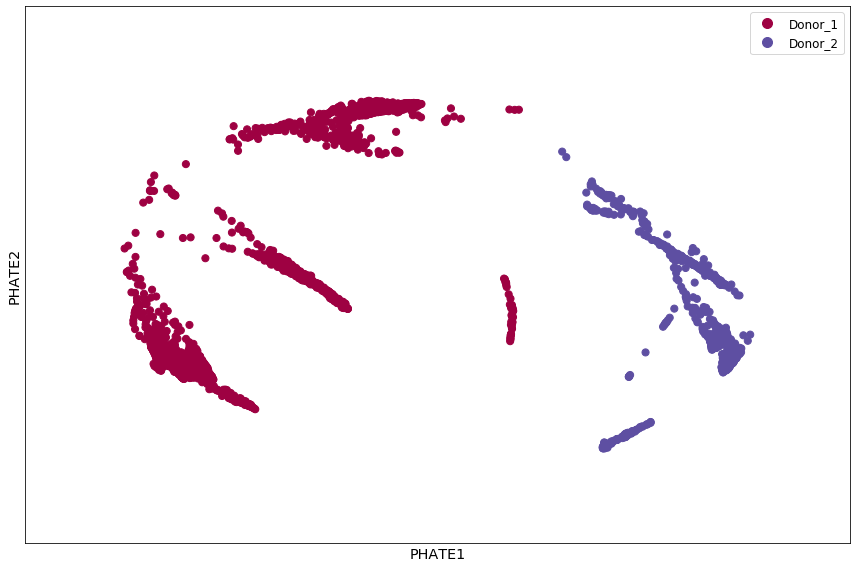

In [28]:
scprep.plot.scatter2d(data_phate, c=metadata['sample_labels'], figsize=(12,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE", s = 50)

What is going on in this visualization? What do you think is driving this visualization?

# 4. Visualizing imputed gene expression on visualization

To check our suspicions about this dataset, let's check some cell type specific markers. Please visualize each of the pre-selected marker gene and describe what you find!

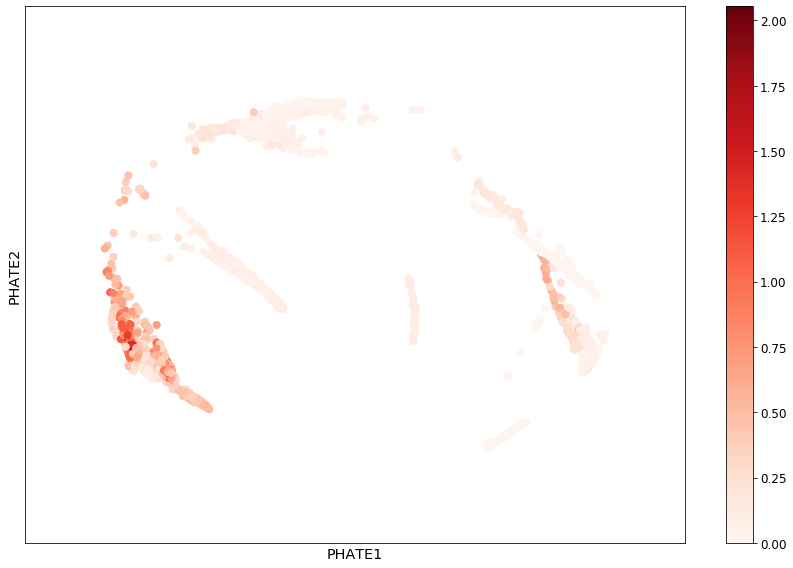

In [27]:
expression = scprep.select.select_cols(data_magic, exact_word='CD8A') # Please enter each of the marker genes here

scprep.plot.scatter2d(data_phate, c=expression, figsize=(12,8), cmap="Reds",
                      ticks=False, label_prefix="PHATE", s = 50)

# 5. Correcting differences between samples

There are several algorithms that try to correct systemic sample level differences present in single cell datasets. Here, we will implement MNN correction to try and remove these differences. Herein, we will first create an AnnData object from our data before running it through MNN to get corrected data. We can then use this data to re-impute gene expression and re-visualize our data.

In [30]:
import scanpy as sc

pbmc_anndata = sc.AnnData(X=data, obs = metadata)

In [31]:
batches = ["Donor_1","Donor_2"]
alldata = {}

for batch in batches:
    alldata[batch] = pbmc_anndata[pbmc_anndata.obs['sample_labels']==batch,]


In [32]:
cdata = sc.external.pp.mnn_correct(alldata['Donor_1'], alldata['Donor_2'], svd_dim=50, 
                                  batch_key = 'sample_labels', batch_categories=["Donor_1","Donor_2"])

/home/mkuchroo/.local/lib/python3.8/site-packages/mnnpy/utils.py:14: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "l2_norm" failed type inference due to: Invalid use of Function(<function norm at 0x7f4b0c90c9d0>) with argument(s) of type(s): (axis=Literal[int](1), x=array(float32, 2d, A))
 * parameterized
In definition 0:
    TypeError: norm_impl() got an unexpected keyword argument 'x'
    raised from /home/mkuchroo/.local/lib/python3.8/site-packages/numba/core/typing/templates.py:579
In definition 1:
    TypeError: norm_impl() got an unexpected keyword argument 'x'
    raised from /home/mkuchroo/.local/lib/python3.8/site-packages/numba/core/typing/templates.py:579
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function norm at 0x7f4b0c90c9d0>)
[2] During: typing of call at /home/mkuchroo/.local/lib/python3.8/site-packages/mnnpy/

/home/mkuchroo/.local/lib/python3.8/site-packages/mnnpy/utils.py:199: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "adjust_s_variance" failed type inference due to: Untyped global name 'sq_dist_to_line': cannot determine Numba type of <class 'numba.core.ir.UndefinedType'>

File "../.local/lib/python3.8/site-packages/mnnpy/utils.py", line 209:
def adjust_s_variance(data1, data2, curcell, curvect, sigma):
    <source elided>
        sameproj = np.dot(grad, samecell)
        samedist = sq_dist_to_line(curcell, grad, samecell)
        ^

  @jit(float32(float32[:, :], float32[:, :], float32[:], float32[:], float32), nogil=True)
/home/mkuchroo/.local/lib/python3.8/site-packages/mnnpy/utils.py:199: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "adjust_s_variance" failed type inference due to: cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "../.local/

Performing cosine normalization...


/home/mkuchroo/.local/lib/python3.8/site-packages/mnnpy/utils.py:14: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "l2_norm" failed type inference due to: Invalid use of Function(<function norm at 0x7f4b0c90c9d0>) with argument(s) of type(s): (axis=Literal[int](1), x=array(float32, 2d, A))
 * parameterized
In definition 0:
    TypeError: norm_impl() got an unexpected keyword argument 'x'
    raised from /home/mkuchroo/.local/lib/python3.8/site-packages/numba/core/typing/templates.py:579
In definition 1:
    TypeError: norm_impl() got an unexpected keyword argument 'x'
    raised from /home/mkuchroo/.local/lib/python3.8/site-packages/numba/core/typing/templates.py:579
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function norm at 0x7f4b0c90c9d0>)
[2] During: typing of call at /home/mkuchroo/.local/lib/python3.8/site-packages/mnnpy/

Starting MNN correct iteration. Reference batch: 0
Step 1 of 1: processing batch 1
  Looking for MNNs...


/home/mkuchroo/.local/lib/python3.8/site-packages/mnnpy/utils.py:88: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "find_mutual_nn" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at /home/mkuchroo/.local/lib/python3.8/site-packages/mnnpy/utils.py (94)

File "../.local/lib/python3.8/site-packages/mnnpy/utils.py", line 94:
def find_mutual_nn(data1, data2, k1, k2, n_jobs):
    <source elided>
    mutual_2 = []
    for index_2 in range(data2.shape[0]):
    ^

  @jit((float32[:, :], float32[:, :], int8, int8, int8))
/home/mkuchroo/.local/lib/python3.8/site-packages/numba/core/object_mode_passes.py:177: NumbaWarning: Function "find_mutual_nn" was compiled in object mode without forceobj=True.

File "../.local/lib/python3.8/site-packages/mnnpy/utils.py", line 94:
def find_mutual_nn(data1, data2, k1, k2, n_jobs):
    <source elided>
    mutual_2 = []
    for index_2 in range(data2.shape[0]):
    ^


  Computing correction vectors...


/home/mkuchroo/.local/lib/python3.8/site-packages/mnnpy/utils.py:102: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "compute_correction" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at /home/mkuchroo/.local/lib/python3.8/site-packages/mnnpy/utils.py (107)

File "../.local/lib/python3.8/site-packages/mnnpy/utils.py", line 107:
def compute_correction(data1, data2, mnn1, mnn2, data2_or_raw2, sigma):
    <source elided>
    vect_reduced = np.zeros((data2.shape[0], vect.shape[1]), dtype=np.float32)
    for index, ve in zip(mnn2, vect):
    ^

  @jit(float32[:, :](float32[:, :], float32[:, :], int32[:], int32[:], float32[:, :], float32))
/home/mkuchroo/.local/lib/python3.8/site-packages/numba/core/object_mode_passes.py:177: NumbaWarning: Function "compute_correction" was compiled in object mode without forceobj=True.

File "../.local/lib/python3.8/site-packages/mnnpy/utils.py", line 107:
def co

  Removing components...
  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...
Done.


# 6. Visualizing gene expression on corrected data

Now that we have a batch corrected dataset, let's visualize imputed gene expression on the aligned manifold. Let us know what you think!

In [57]:
cdata_magic = magic.MAGIC().fit_transform(cdata[0], genes=marker_genes)

cdata_magic = pd.DataFrame(cdata_magic.X)
cdata_magic.columns = marker_genes
cdata_index = data.index

Calculating MAGIC...
  Running MAGIC on 5199 cells and 10817 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.15 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.47 seconds.
    Calculating affinities...
    Calculated affinities in 2.43 seconds.
  Calculated graph and diffusion operator in 6.07 seconds.
  Calculating imputation...
Calculated MAGIC in 6.16 seconds.


In [34]:
cdata_phate = phate.PHATE().fit_transform(cdata[0])

Calculating PHATE...
  Running PHATE on 5199 cells and 10817 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.09 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.71 seconds.
    Calculating affinities...
    Calculated affinities in 0.53 seconds.
  Calculated graph and diffusion operator in 4.35 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.56 seconds.
    Calculating KMeans...
    Calculated KMeans in 19.57 seconds.
  Calculated landmark operator in 21.59 seconds.
  Calculating optimal t...
  Calculated optimal t in 0.89 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.32 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 7.02 seconds.
Calculated PHATE in 34.19 seconds.


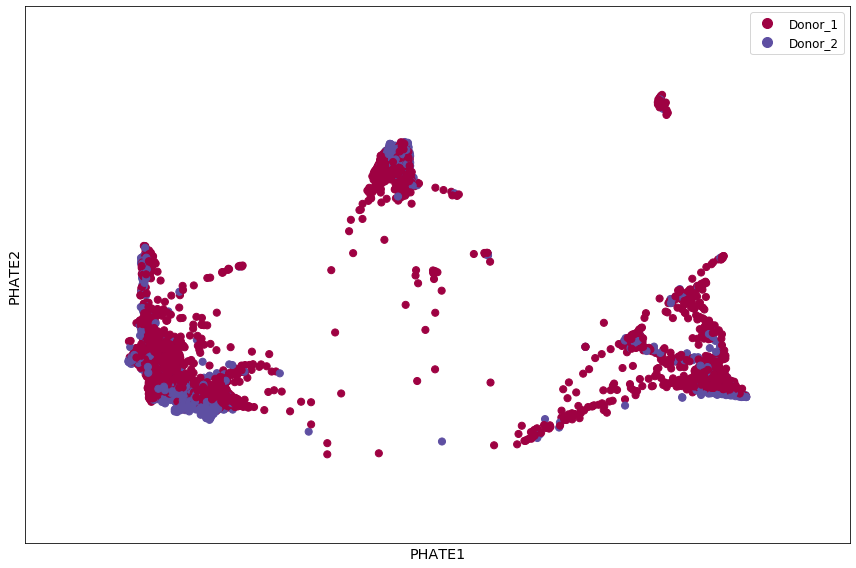

In [35]:
scprep.plot.scatter2d(cdata_phate, c=metadata['sample_labels'], figsize=(12,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE", s = 50)

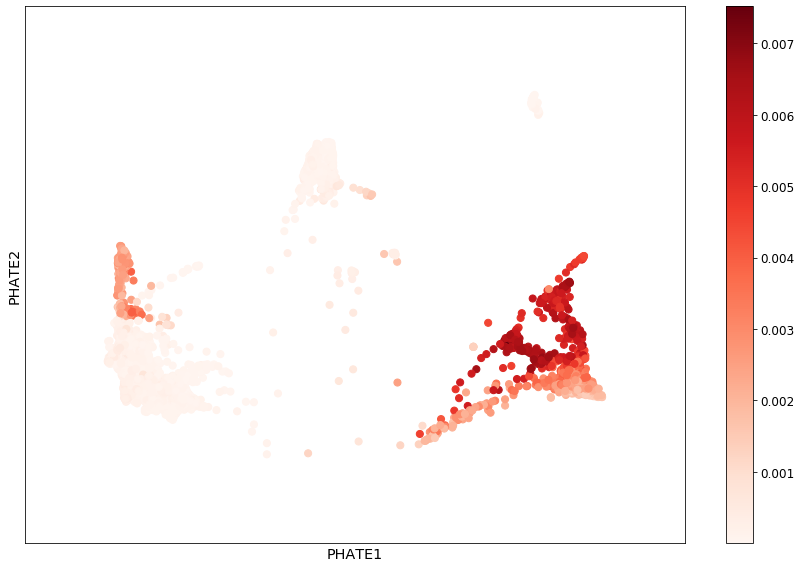

In [62]:
expression = scprep.select.select_cols(cdata_magic, exact_word='ITGAX') # Please enter each of the marker genes here

scprep.plot.scatter2d(cdata_phate, c=expression, figsize=(12,8), cmap="Reds",
                      ticks=False, label_prefix="PHATE", s = 50)